In [ ]:
# Authors
# Hamza Khalid
# Hamza Iftikhar
# Syed Abdullah Nasir 

In [37]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
import cv2
import os 
import glob
%matplotlib inline

In [38]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [40]:
main_path = "./data"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [41]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [42]:
df_train.head()

,class,image
0,Normal,./data\train/NORMAL\NORMAL-1003233-0001.jpeg
1,Normal,./data\train/NORMAL\NORMAL-1012843-0001.jpeg
2,Normal,./data\train/NORMAL\NORMAL-1014768-0001.jpeg
3,Normal,./data\train/NORMAL\NORMAL-1023731-0001.jpeg
4,Normal,./data\train/NORMAL\NORMAL-1029510-0001.jpeg


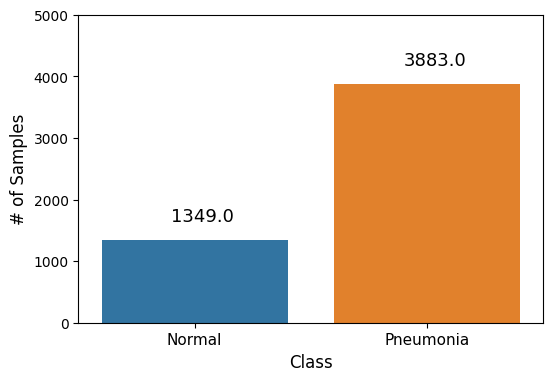

In [43]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train)

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

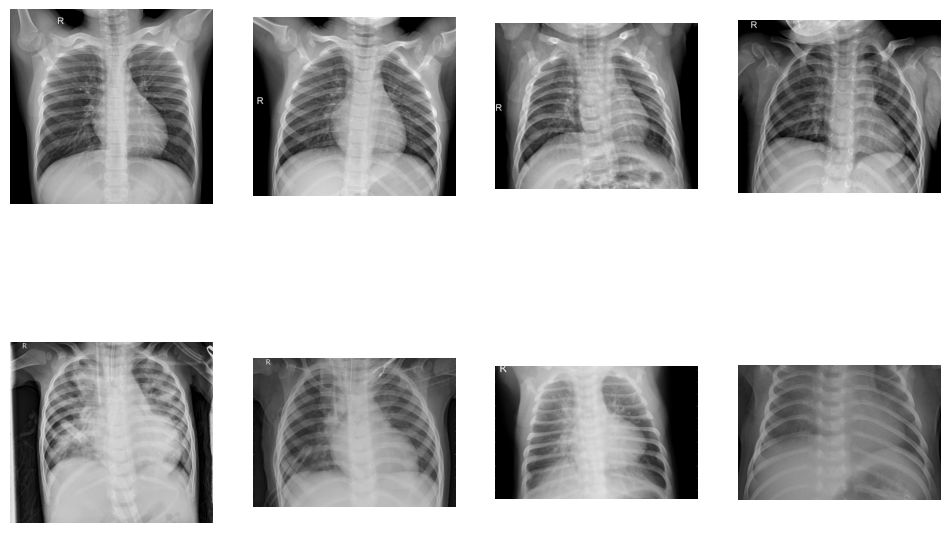

In [44]:
plt.figure(figsize=(12,12))

for i in range(8):
    plt.subplot(3,4,i+1)
    if i < 4:
        plt.imshow(cv2.imread(train_normal[i]))
    else:
        plt.imshow(cv2.imread(train_pneumonia[i-4]))
    plt.axis('off')

plt.show()


In [45]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [46]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.0)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [47]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.5,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [48]:
def get_model():    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [49]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy' ,optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [51]:
%%timeit -n1 -r1 
history = None
with tf.device('/GPU:0'):    
    history = model.fit(ds_train,
            batch_size = BATCH, epochs = 50,
            validation_data=ds_val,
            callbacks=[early_stopping, plateau],
            steps_per_epoch=(len(train_df)/BATCH),
            validation_steps=(len(val_df)/BATCH))

Epoch 1/50
130/130 [==============================] - 67s 461ms/step - loss: 0.5486 - binary_accuracy: 0.7515 - val_loss: 0.5985 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 71s 543ms/step - loss: 0.3895 - binary_accuracy: 0.8229 - val_loss: 0.9093 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/50
131/130 [==============================] - ETA: 0s - loss: 0.3321 - binary_accuracy: 0.8509
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
130/130 [==============================] - 53s 406ms/step - loss: 0.3321 - binary_accuracy: 0.8509 - val_loss: 0.9036 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 4/50
130/130 [==============================] - 67s 511ms/step - loss: 0.2766 - binary_accuracy: 0.8910 - val_loss: 1.0425 - val_binary_accuracy: 0.7421 - lr: 1.5000e-05
Epoch 5/50
131/130 [==============================] - ETA: 0s - loss: 0.2684 - binary_accuracy: 0.8877
Epoch 5: ReduceLROnPlate

In [52]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.14844775199890137
Val accuracy: 0.946513831615448


In [53]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.45570558309555054
Test accuracy: 0.8221153616905212


# Prediction

1/1 [==============================] - 0s 23ms/step
Normal


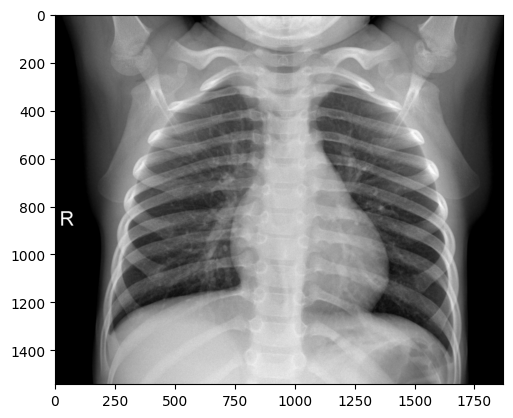

In [62]:
img = cv2.imread(test_normal[10])
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = np.reshape(img, [1, IMG_SIZE, IMG_SIZE, 3])
img = img/255.

classes = model.predict(img)
if classes > 0.5:
    print('Pneumonia')
else:
    print('Normal')

plt.imshow(cv2.imread(test_normal[10]))
plt.show()



1/1 [==============================] - 0s 18ms/step
Pneumonia


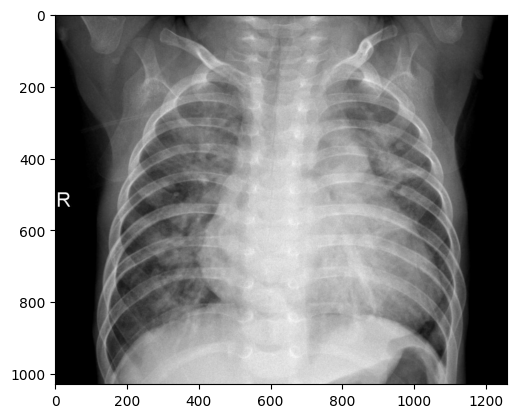

In [63]:
img = cv2.imread(test_pneumonia[10])
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = np.reshape(img, [1, IMG_SIZE, IMG_SIZE, 3])
img = img/255.

classes = model.predict(img)
if classes > 0.5:
    print('Pneumonia')
else:
    print('Normal')

plt.imshow(cv2.imread(test_pneumonia[10]))
plt.show()